# NLP Multi classification with 

Notebook to prepare the tensorflow Certified Developer. 

Multiple Text Classification 

Dataset from: 
https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data




## Import libraries

In [1]:
#First steep is import the libraries. 
import tensorflow as tf
tf.random.set_seed(42)
#Numpy is a lybrary that allow us to work with arrays. 
import numpy as np
#keras is an open source neural networks lybrary writted in python that run's in varios frameworks, TensorFlow included. 
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import csv

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import linregress

#Tranfer learning from tensorhub
import tensorflow_hub as hub

print (tf.__version__)

gEpochs = 10

2.9.0


# Functions


In [2]:
#clear the text 
import re
def cleanText(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

In [26]:
def get_model(kindmodel):
    switcher = {
        #FLATTEN
        #38s 35ms/step - loss: 0.3960 - accuracy: 0.8109 - val_loss: 1.2877 - val_accuracy: 0.6138
        0:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(5, activation='softmax')]), 
        #GLOBALAVERAGE
        #39s 35ms/step - loss: 0.6244 - accuracy: 0.7387 - val_loss: 1.0061 - val_accuracy: 0.6216
        1:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.GlobalAveragePooling1D(), 
            tf.keras.layers.Dense(128, activation='relu'), 
            tf.keras.layers.Dense(5, activation='softmax')]),
        #GlobalAverage + ExtraDense + Dropout
        #24s 22ms/step - loss: 0.7189 - accuracy: 0.7069 - val_loss: 0.9867 - val_accuracy: 0.6298
        11:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
            tf.keras.layers.GlobalAveragePooling1D(), 
            tf.keras.layers.Dense(64, activation='relu'), 
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.4), 
            tf.keras.layers.Dense(5, activation='softmax')]),
        #LSTM Simple
        #64s 58ms/step - loss: 0.4613 - accuracy: 0.7915 - val_loss: 1.3056 - val_accuracy: 0.6298
        2:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(5, activation='softmax')]), 
        #LSTM Multiple with return
        #89s 81ms/step - loss: 0.4952 - accuracy: 0.7785 - val_loss: 1.2355 - val_accuracy: 0.6352
        3:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(5, activation='softmax')]),
        #LSTM Multiple with Dropouts
        #84s 76ms/step - loss: 0.5151 - accuracy: 0.7722 - val_loss: 1.1840 - val_accuracy: 0.6375
        31:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim), 
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(5, activation='softmax')]),
        
        #Multiple LSTM With Intern Dropouts in LSTM Layer
        #69s 63ms/step - loss: 0.7109 - accuracy: 0.7085 - val_loss: 0.8902 - val_accuracy: 0.6536
        32:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.8, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(5, activation='softmax')]),
        #Convolutional GlobalMaxPooling
        #31s 28ms/step - loss: 0.3724 - accuracy: 0.8374 - val_loss: 1.3006 - val_accuracy: 0.6141
        4:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(5, activation='softmax')]),
        #Convolutional GlovalAveragePooling & Dropout
        #33s 30ms/step - loss: 0.6377 - accuracy: 0.7297 - val_loss: 0.9625 - val_accuracy: 0.6362
        5:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(5, activation='softmax')]),
        #Mix Layers
        #https://docs.google.com/document/d/1X7nmy6T6eZsrJ6kvlpyAbzsp2o0D7jVxLotMRghB-Mo/edit#heading=h.ns089nepq1wb
        # I removed the recurrent_layout in LSTM layers, because of a x40 increment in training time
        #38s 137ms/step - loss: 0.8886 - accuracy: 0.6414 - val_loss: 0.8992 - val_accuracy: 0.6456
        6:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.SpatialDropout1D(0.4),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,dropout = 0.5,recurrent_dropout=0.5,return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.8, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.5, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8,return_sequences=False)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(5,activation='softmax')]),
        #Without the GRU layer
        #29s 107ms/step - loss: 0.8181 - accuracy: 0.6642 - val_loss: 0.8873 - val_accuracy: 0.6510
        61:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.SpatialDropout1D(0.4),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,dropout = 0.5,recurrent_dropout=0.5,return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.8, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.5, return_sequences=False)),
            #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8,return_sequences=False)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(5,activation='softmax')]),
    }
    return switcher.get(kindmodel, None)

In [4]:

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo-', label='Training Loss')
  plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [5]:
#Get the data from the .csv without pandas. 
def parse_data(filename, xpos, ypos,  omitheaders=True, delimiter=',', returnlabels=True):
    tweets = []
    labels = []
    
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        if omitheaders:
            csvfile.readline()
        for line in reader:
            tweets.append(cleanText(line[xpos]))
            if returnlabels:
                labels.append(int(line[ypos]))
    
    return tweets, labels


In [6]:
#split the data in tarning / validate data 
def split_data(data, label, validation=10):
    validsize = int(len(data) * (validation / 100))
    total_length = len(data)
    v_data = data[0:validsize]
    t_data = data[validsize:]
    
    v_label = label[0:validsize]
    t_label = label[validsize:]
    
    return  t_data, t_label, v_data, v_label

### prepare the data for the model

In [7]:
traindatafile = "./Data/Sentiment/train.tsv"
testdatafile = "./Data/Sentiment/test.tsv"

In [8]:
with open(traindatafile, 'r') as train_df:
    print (train_df.readline())
    print (train_df.readline())

PhraseId	SentenceId	Phrase	Sentiment

1	1	A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .	1



In [9]:
with open(testdatafile, 'r') as test_df:
    print (test_df.readline())
    print (test_df.readline())

PhraseId	SentenceId	Phrase

156061	8545	An intermittently pleasing but mostly routine effort .



In [10]:
x_traindata, y_traindata = parse_data(traindatafile, 2, 3, delimiter='\t')
print(x_traindata[0])
print(len(x_traindata))
print(y_traindata[0])



a series of escapades demonstrating the adage that what is good for the goose is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story 
156060
1


In [11]:
x_test, y_test = parse_data(testdatafile, 2, 0, returnlabels=False, delimiter='\t')

In [12]:
x_train, y_train, x_val, y_val=split_data(x_traindata, y_traindata, validation =10)
print (len(x_train))
print (len(y_train))
print (len(x_val))
print (len(y_val))
print (x_train[0])
print (x_val[0])

140454
140454
15606
15606
one point in this movie
a series of escapades demonstrating the adage that what is good for the goose is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story 


In [31]:
# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

vocab_size = 14000
max_length = 48
embedding_dim = 100


In [32]:
max_length  = max([len(s.split()) for s in x_train])
print (max_length)

48


In [33]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(list(x_train))
word_index = tokenizer.word_index
print(f'number of words in word_index: {len(word_index)}')

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(x_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
validation_sequences = tokenizer.texts_to_sequences(x_val)
validation_padded = pad_sequences(validation_sequences, 
                               maxlen=max_length, truncating=trunc_type)

y_train = np.array(y_train)
y_val = np.array(y_val)

number of words in word_index: 15497


# Flatten



In [16]:
model0 = get_model(0)

# Setup the training parameters
model0.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model0.summary()

Metal device set to: Apple M1 Pro


2022-07-29 12:15:01.980550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-29 12:15:01.980657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 100)           1400000   
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                                 
 dense (Dense)               (None, 128)               614528    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,015,173
Trainable params: 2,015,173
Non-trainable params: 0
_________________________________________________________________


In [17]:
history0 = model0.fit(padded,  y_train, batch_size=128, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 12:15:04.502894: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-29 12:15:04.672808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - ETA: 0s - loss: 0.9687 - accuracy: 0.6108

2022-07-29 12:15:43.605720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - 40s 36ms/step - loss: 0.9687 - accuracy: 0.6108 - val_loss: 0.9087 - val_accuracy: 0.6405
Epoch 2/10
1098/1098 [==============================] - 38s 35ms/step - loss: 0.7346 - accuracy: 0.6970 - val_loss: 0.9063 - val_accuracy: 0.6389
Epoch 3/10
1098/1098 [==============================] - 38s 35ms/step - loss: 0.6447 - accuracy: 0.7295 - val_loss: 0.9287 - val_accuracy: 0.6377
Epoch 4/10
1098/1098 [==============================] - 38s 34ms/step - loss: 0.5817 - accuracy: 0.7510 - val_loss: 0.9592 - val_accuracy: 0.6321
Epoch 5/10
1098/1098 [==============================] - 38s 34ms/step - loss: 0.5351 - accuracy: 0.7648 - val_loss: 1.0118 - val_accuracy: 0.6237
Epoch 6/10
1098/1098 [==============================] - 38s 34ms/step - loss: 0.4966 - accuracy: 0.7759 - val_loss: 1.0536 - val_accuracy: 0.6241
Epoch 7/10
1098/1098 [==============================] - 38s 34ms/step - loss: 0.4661 - accuracy: 0.7859 - val_loss: 1.1102 - val_accura

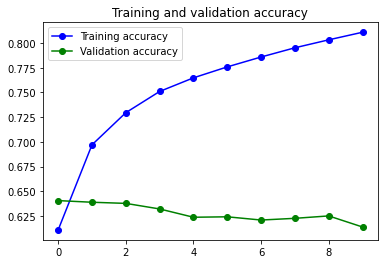

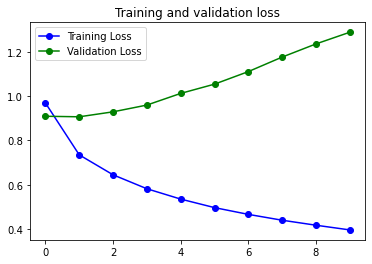

In [18]:
plot_loss_acc(history0)

## model 1 GlobalAverage


In [19]:
model1 = get_model(1)

model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 48, 100)           1400000   
                                                                 
 global_average_pooling1d_3   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_22 (Dense)            (None, 128)               12928     
                                                                 
 dense_23 (Dense)            (None, 5)                 645       
                                                                 
Total params: 1,413,573
Trainable params: 1,413,573
Non-trainable params: 0
_________________________________________________________________


In [20]:
history1 = model1.fit(padded, y_train, epochs=gEpochs, batch_size=128,
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 12:21:27.397273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - ETA: 0s - loss: 1.1239 - accuracy: 0.5536

2022-07-29 12:22:06.761488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - 40s 36ms/step - loss: 1.1239 - accuracy: 0.5536 - val_loss: 0.9662 - val_accuracy: 0.6211
Epoch 2/10
1098/1098 [==============================] - 39s 35ms/step - loss: 0.8510 - accuracy: 0.6547 - val_loss: 0.9252 - val_accuracy: 0.6369
Epoch 3/10
1098/1098 [==============================] - 39s 35ms/step - loss: 0.7775 - accuracy: 0.6827 - val_loss: 0.9259 - val_accuracy: 0.6416
Epoch 4/10
1098/1098 [==============================] - 39s 35ms/step - loss: 0.7374 - accuracy: 0.6997 - val_loss: 0.9613 - val_accuracy: 0.6255
Epoch 5/10
1098/1098 [==============================] - 39s 35ms/step - loss: 0.7095 - accuracy: 0.7095 - val_loss: 0.9399 - val_accuracy: 0.6359
Epoch 6/10
1098/1098 [==============================] - 39s 35ms/step - loss: 0.6873 - accuracy: 0.7155 - val_loss: 0.9532 - val_accuracy: 0.6316
Epoch 7/10
1098/1098 [==============================] - 39s 35ms/step - loss: 0.6693 - accuracy: 0.7236 - val_loss: 0.9603 - val_accura

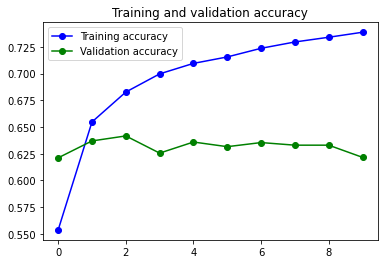

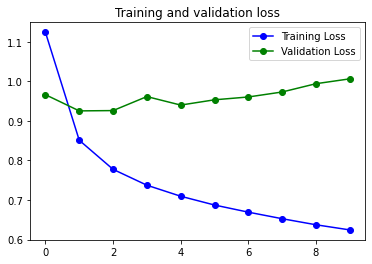

In [21]:
plot_loss_acc(history1)

In [22]:
model11 = get_model(11)

# Setup the training parameters
model11.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model11.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 48, 16)            224000    
                                                                 
 global_average_pooling1d_7   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_44 (Dense)            (None, 64)                1088      
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_46 (Dense)            (None, 5)                 165       
                                                     

In [23]:
history111 = model11.fit(padded, y_train, epochs=gEpochs, batch_size=128,
          validation_data=(validation_padded, y_val))

Epoch 1/10
   1/1098 [..............................] - ETA: 6:51 - loss: 1.6130 - accuracy: 0.1484

2022-07-29 12:27:57.660642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - ETA: 0s - loss: 1.2334 - accuracy: 0.5134

2022-07-29 12:28:23.721562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - 27s 24ms/step - loss: 1.2334 - accuracy: 0.5134 - val_loss: 1.0828 - val_accuracy: 0.5729
Epoch 2/10
1098/1098 [==============================] - 24s 22ms/step - loss: 1.1025 - accuracy: 0.5549 - val_loss: 1.0521 - val_accuracy: 0.5855
Epoch 3/10
1098/1098 [==============================] - 24s 22ms/step - loss: 1.0305 - accuracy: 0.5859 - val_loss: 0.9752 - val_accuracy: 0.6233
Epoch 4/10
1098/1098 [==============================] - 24s 22ms/step - loss: 0.8801 - accuracy: 0.6472 - val_loss: 0.9471 - val_accuracy: 0.6292
Epoch 5/10
1098/1098 [==============================] - 24s 22ms/step - loss: 0.8125 - accuracy: 0.6703 - val_loss: 0.9382 - val_accuracy: 0.6389
Epoch 6/10
1098/1098 [==============================] - 24s 22ms/step - loss: 0.7784 - accuracy: 0.6827 - val_loss: 0.9472 - val_accuracy: 0.6324
Epoch 7/10
1098/1098 [==============================] - 24s 22ms/step - loss: 0.7579 - accuracy: 0.6927 - val_loss: 0.9547 - val_accura

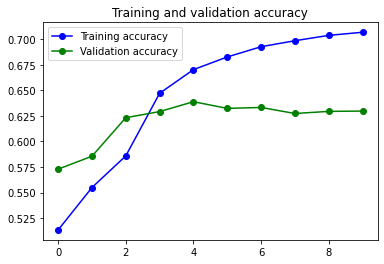

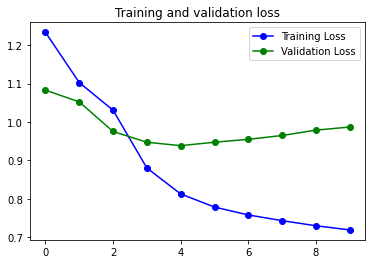

In [24]:
plot_loss_acc(history111)

## Single Layer LSTM

In [30]:
# Build the model
model2 = get_model(2)

# Print the model summary
model2.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, None, 100)         1400000   
                                                                 
 bidirectional_47 (Bidirecti  (None, 128)              84480     
 onal)                                                           
                                                                 
 dense_90 (Dense)            (None, 64)                8256      
                                                                 
 dense_91 (Dense)            (None, 5)                 325       
                                                                 
Total params: 1,493,061
Trainable params: 1,493,061
Non-trainable params: 0
_________________________________________________________________


In [34]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history2 = model2.fit(padded, y_train, epochs=gEpochs, batch_size=128,
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 17:06:36.506033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 17:06:36.733748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 17:06:36.744670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 17:06:37.055958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 17:06:37.071035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - ETA: 0s - loss: 0.9656 - accuracy: 0.6091

2022-07-29 17:07:43.488571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 17:07:43.582304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 17:07:43.590088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - 71s 62ms/step - loss: 0.9656 - accuracy: 0.6091 - val_loss: 0.8961 - val_accuracy: 0.6464
Epoch 2/10
1098/1098 [==============================] - 64s 58ms/step - loss: 0.7674 - accuracy: 0.6849 - val_loss: 0.8834 - val_accuracy: 0.6523
Epoch 3/10
1098/1098 [==============================] - 64s 58ms/step - loss: 0.6961 - accuracy: 0.7088 - val_loss: 0.9007 - val_accuracy: 0.6493
Epoch 4/10
1098/1098 [==============================] - 65s 59ms/step - loss: 0.6440 - accuracy: 0.7277 - val_loss: 0.9244 - val_accuracy: 0.6494
Epoch 5/10
1098/1098 [==============================] - 64s 58ms/step - loss: 0.6064 - accuracy: 0.7406 - val_loss: 0.9594 - val_accuracy: 0.6470
Epoch 6/10
1098/1098 [==============================] - 65s 59ms/step - loss: 0.5732 - accuracy: 0.7518 - val_loss: 1.0035 - val_accuracy: 0.6431
Epoch 7/10
1098/1098 [==============================] - 65s 59ms/step - loss: 0.5442 - accuracy: 0.7615 - val_loss: 1.0482 - val_accura

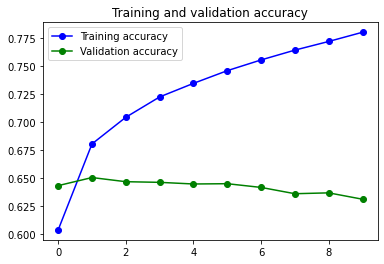

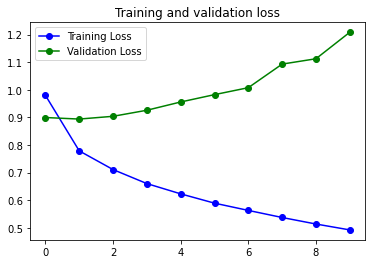

In [28]:
plot_loss_acc(history2)

# Multiple LSTM

In [29]:
# Build the model
model3 = get_model(3)
# Print the model summary
model3.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, None, 64)          896000    
                                                                 
 bidirectional_41 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_42 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_89 (Dense)            (None, 64)                4160      
                                                                 
 dense_90 (Dense)            (None, 5)                 325       
                                                                 
Total params: 1,007,749
Trainable params: 1,007,749
N

In [30]:
# Set the training parameters
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
history3 = model3.fit(padded, y_train, epochs=gEpochs, batch_size=128,
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 12:41:33.763297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:41:34.135406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:41:34.145856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:41:34.265272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:41:34.275552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:41:34.431794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:41:34.447142: I tensorflow/core/grappler/optimizers/cust

1098/1098 [==============================] - ETA: 0s - loss: 1.0006 - accuracy: 0.5969

2022-07-29 12:42:57.562750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:42:57.701869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:42:57.709216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:42:57.848878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:42:57.856372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - 90s 79ms/step - loss: 1.0006 - accuracy: 0.5969 - val_loss: 0.9031 - val_accuracy: 0.6419
Epoch 2/10
1098/1098 [==============================] - 82s 75ms/step - loss: 0.7878 - accuracy: 0.6781 - val_loss: 0.8862 - val_accuracy: 0.6474
Epoch 3/10
1098/1098 [==============================] - 83s 76ms/step - loss: 0.7181 - accuracy: 0.7036 - val_loss: 0.8984 - val_accuracy: 0.6474
Epoch 4/10
1098/1098 [==============================] - 84s 76ms/step - loss: 0.6687 - accuracy: 0.7205 - val_loss: 0.9279 - val_accuracy: 0.6419
Epoch 5/10
1098/1098 [==============================] - 83s 76ms/step - loss: 0.6351 - accuracy: 0.7317 - val_loss: 0.9462 - val_accuracy: 0.6426
Epoch 6/10
1098/1098 [==============================] - 83s 76ms/step - loss: 0.6054 - accuracy: 0.7426 - val_loss: 0.9706 - val_accuracy: 0.6428
Epoch 7/10
1098/1098 [==============================] - 83s 76ms/step - loss: 0.5814 - accuracy: 0.7506 - val_loss: 0.9926 - val_accura

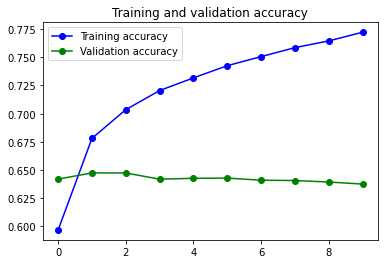

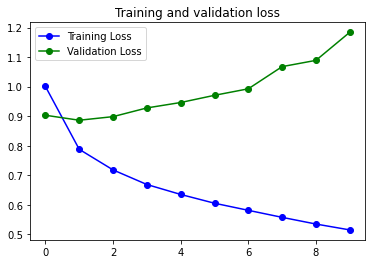

In [32]:
plot_loss_acc(history3)

In [33]:
# Build the model
model31 = get_model(31)
# Print the model summary
model31.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, None, 64)          896000    
                                                                 
 bidirectional_53 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_54 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_111 (Dense)           (None, 64)                4160      
                                                                 
 dropout_32 (Dropout)        (None, 64)              

In [34]:
# Set the training parameters
model31.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history31 = model31.fit(padded, y_train, epochs=gEpochs, batch_size=128,
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 12:55:39.746794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:55:40.128713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:55:40.148245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:55:40.317684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:55:40.328173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:55:40.628969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:55:40.644244: I tensorflow/core/grappler/optimizers/cust

1098/1098 [==============================] - ETA: 0s - loss: 1.0266 - accuracy: 0.5891

2022-07-29 12:57:07.030659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:57:07.171834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:57:07.179068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:57:07.309064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 12:57:07.316857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - 93s 82ms/step - loss: 1.0266 - accuracy: 0.5891 - val_loss: 0.9141 - val_accuracy: 0.6381
Epoch 2/10
1098/1098 [==============================] - 85s 77ms/step - loss: 0.8072 - accuracy: 0.6720 - val_loss: 0.8922 - val_accuracy: 0.6490
Epoch 3/10
1098/1098 [==============================] - 84s 76ms/step - loss: 0.7372 - accuracy: 0.6962 - val_loss: 0.8978 - val_accuracy: 0.6465
Epoch 4/10
1098/1098 [==============================] - 83s 76ms/step - loss: 0.6899 - accuracy: 0.7120 - val_loss: 0.9096 - val_accuracy: 0.6456
Epoch 5/10
1098/1098 [==============================] - 83s 76ms/step - loss: 0.6558 - accuracy: 0.7233 - val_loss: 0.9349 - val_accuracy: 0.6366
Epoch 6/10
1098/1098 [==============================] - 84s 76ms/step - loss: 0.6278 - accuracy: 0.7333 - val_loss: 0.9487 - val_accuracy: 0.6419
Epoch 7/10
1098/1098 [==============================] - 83s 76ms/step - loss: 0.6049 - accuracy: 0.7411 - val_loss: 0.9702 - val_accura

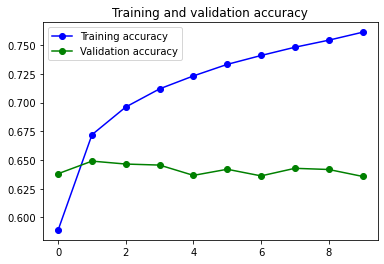

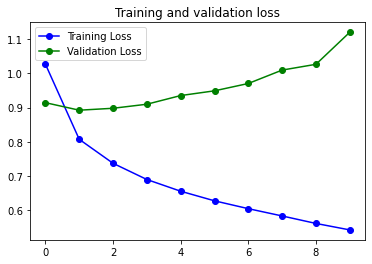

In [36]:
plot_loss_acc(history31)

In [37]:
# Build the model
model32 = get_model(32)
# Print the model summary
model32.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_66 (Embedding)    (None, None, 64)          896000    
                                                                 
 bidirectional_65 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_66 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_133 (Dense)           (None, 64)                4160      
                                                                 
 dense_134 (Dense)           (None, 5)                 325       
                                                                 
Total params: 1,007,749
Trainable params: 1,007,749
N

In [38]:
#Set the training parameters
model32.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history32 = model32.fit(padded, y_train, epochs=gEpochs, batch_size=128,
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 13:09:45.537233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:09:45.993996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:09:46.004395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:09:46.186168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:09:46.196448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:09:46.398885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:09:46.415016: I tensorflow/core/grappler/optimizers/cust

1098/1098 [==============================] - ETA: 0s - loss: 1.1232 - accuracy: 0.5513

2022-07-29 13:10:53.150032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:10:53.291819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:10:53.299442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:10:53.428731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 13:10:53.436334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - 74s 64ms/step - loss: 1.1232 - accuracy: 0.5513 - val_loss: 0.9515 - val_accuracy: 0.6216
Epoch 2/10
1098/1098 [==============================] - 66s 60ms/step - loss: 0.9295 - accuracy: 0.6243 - val_loss: 0.8896 - val_accuracy: 0.6453
Epoch 3/10
1098/1098 [==============================] - 66s 60ms/step - loss: 0.8637 - accuracy: 0.6481 - val_loss: 0.8841 - val_accuracy: 0.6485
Epoch 4/10
1098/1098 [==============================] - 65s 60ms/step - loss: 0.8299 - accuracy: 0.6608 - val_loss: 0.8805 - val_accuracy: 0.6494
Epoch 5/10
1098/1098 [==============================] - 65s 59ms/step - loss: 0.8062 - accuracy: 0.6713 - val_loss: 0.8854 - val_accuracy: 0.6517
Epoch 6/10
1098/1098 [==============================] - 65s 59ms/step - loss: 0.7902 - accuracy: 0.6762 - val_loss: 0.8857 - val_accuracy: 0.6533
Epoch 7/10
1098/1098 [==============================] - 65s 59ms/step - loss: 0.7751 - accuracy: 0.6830 - val_loss: 0.8838 - val_accura

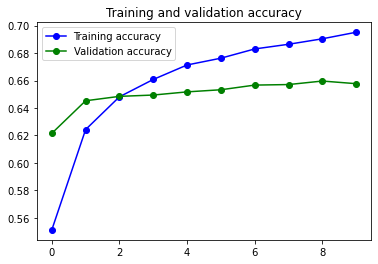

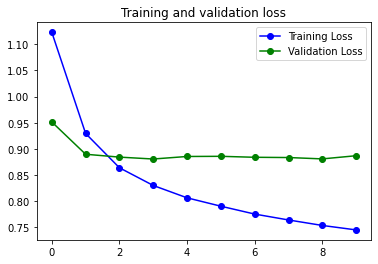

In [39]:
plot_loss_acc(history32)

# Convolutional Model

In [40]:
# Build the model
model4 = get_model(4)
# Print the model summary
model4.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_77 (Embedding)    (None, 48, 64)            896000    
                                                                 
 conv1d_14 (Conv1D)          (None, 44, 64)            20544     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_155 (Dense)           (None, 64)                4160      
                                                                 
 dense_156 (Dense)           (None, 5)                 325       
                                                                 
Total params: 921,029
Trainable params: 921,029
Non-trainable params: 0
_______________________________________________

In [41]:
# Set the training parameters
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history4 = model4.fit(padded, y_train, epochs=gEpochs, batch_size=128,
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 13:20:46.411361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.6083

2022-07-29 13:21:21.441415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - 36s 32ms/step - loss: 0.9744 - accuracy: 0.6083 - val_loss: 0.8825 - val_accuracy: 0.6483
Epoch 2/10
1098/1098 [==============================] - 33s 30ms/step - loss: 0.7451 - accuracy: 0.6945 - val_loss: 0.8781 - val_accuracy: 0.6505
Epoch 3/10
1098/1098 [==============================] - 33s 30ms/step - loss: 0.6579 - accuracy: 0.7246 - val_loss: 0.9061 - val_accuracy: 0.6504
Epoch 4/10
1098/1098 [==============================] - 33s 30ms/step - loss: 0.5935 - accuracy: 0.7490 - val_loss: 0.9236 - val_accuracy: 0.6442
Epoch 5/10
1098/1098 [==============================] - 33s 30ms/step - loss: 0.5432 - accuracy: 0.7677 - val_loss: 0.9812 - val_accuracy: 0.6341
Epoch 6/10
1098/1098 [==============================] - 33s 30ms/step - loss: 0.4991 - accuracy: 0.7855 - val_loss: 1.0245 - val_accuracy: 0.6331
Epoch 7/10
1098/1098 [==============================] - 32s 29ms/step - loss: 0.4616 - accuracy: 0.8005 - val_loss: 1.0829 - val_accura

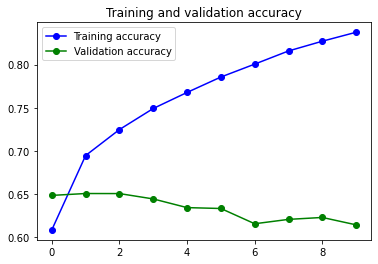

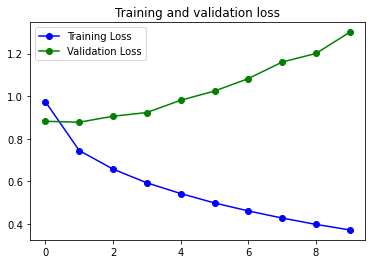

In [42]:
plot_loss_acc(history4)

In [43]:
# Build the model
model5 = get_model(5)
# Print the model summary
model5.summary()

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_88 (Embedding)    (None, 48, 64)            896000    
                                                                 
 conv1d_17 (Conv1D)          (None, 44, 64)            20544     
                                                                 
 dropout_51 (Dropout)        (None, 44, 64)            0         
                                                                 
 global_average_pooling1d_26  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_177 (Dense)           (None, 64)                4160      
                                                                 
 dropout_52 (Dropout)        (None, 64)                0         
                                                     

In [44]:
# Set the training parameters
model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history5 = model5.fit(padded, y_train, epochs=gEpochs, batch_size=128,
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 13:26:18.464334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - ETA: 0s - loss: 1.1103 - accuracy: 0.5611

2022-07-29 13:26:55.008122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1098/1098 [==============================] - 38s 34ms/step - loss: 1.1103 - accuracy: 0.5611 - val_loss: 0.9505 - val_accuracy: 0.6267
Epoch 2/10
1098/1098 [==============================] - 34s 31ms/step - loss: 0.8615 - accuracy: 0.6538 - val_loss: 0.9013 - val_accuracy: 0.6424
Epoch 3/10
1098/1098 [==============================] - 34s 31ms/step - loss: 0.7970 - accuracy: 0.6748 - val_loss: 0.8962 - val_accuracy: 0.6435
Epoch 4/10
1098/1098 [==============================] - 34s 31ms/step - loss: 0.7592 - accuracy: 0.6894 - val_loss: 0.9043 - val_accuracy: 0.6421
Epoch 5/10
1098/1098 [==============================] - 34s 31ms/step - loss: 0.7305 - accuracy: 0.6990 - val_loss: 0.9102 - val_accuracy: 0.6392
Epoch 6/10
1098/1098 [==============================] - 34s 31ms/step - loss: 0.7047 - accuracy: 0.7083 - val_loss: 0.9281 - val_accuracy: 0.6397
Epoch 7/10
1098/1098 [==============================] - 34s 31ms/step - loss: 0.6862 - accuracy: 0.7142 - val_loss: 0.9249 - val_accura

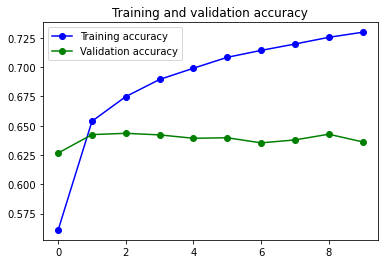

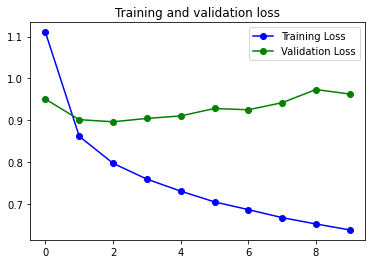

In [45]:
plot_loss_acc(history5)

In [16]:
# Build the model
model6 = get_model(6)
# Print the model summary
model6.summary()

Metal device set to: Apple M1 Pro


2022-07-29 14:04:59.738769: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-29 14:04:59.739075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 48, 100)           1400000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 48, 100)          0         
 ropout1D)                                                       
                                                                 
 bidirectional_7 (Bidirectio  (None, 48, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 48, 64)           41216     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 16)               3552      
 nal)                                                 

In [17]:
# Set the training parameters
model6.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history6 = model6.fit(padded, y_train, epochs=gEpochs, batch_size=512,
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 14:05:29.140910: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-29 14:05:32.436850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:05:32.971415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:05:32.982783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:05:33.123061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:05:33.133880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:05:33.244828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

275/275 [==============================] - ETA: 0s - loss: 1.3345 - accuracy: 0.4778

2022-07-29 14:06:11.820648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:06:11.999560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:06:12.008134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:06:12.110930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:06:12.119891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:06:12.217161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 14:06:12.223760: I tensorflow/core/grappler/optimizers/cust

275/275 [==============================] - 45s 145ms/step - loss: 1.3345 - accuracy: 0.4778 - val_loss: 1.1448 - val_accuracy: 0.5613
Epoch 2/10
275/275 [==============================] - 37s 136ms/step - loss: 1.2375 - accuracy: 0.5109 - val_loss: 1.1117 - val_accuracy: 0.5684
Epoch 3/10
275/275 [==============================] - 37s 135ms/step - loss: 1.1459 - accuracy: 0.5444 - val_loss: 1.0090 - val_accuracy: 0.6046
Epoch 4/10
275/275 [==============================] - 37s 135ms/step - loss: 1.0569 - accuracy: 0.5834 - val_loss: 0.9593 - val_accuracy: 0.6194
Epoch 5/10
275/275 [==============================] - 37s 135ms/step - loss: 1.0010 - accuracy: 0.6034 - val_loss: 0.9319 - val_accuracy: 0.6333
Epoch 6/10
275/275 [==============================] - 37s 135ms/step - loss: 0.9644 - accuracy: 0.6158 - val_loss: 0.9172 - val_accuracy: 0.6364
Epoch 7/10
275/275 [==============================] - 37s 136ms/step - loss: 0.9384 - accuracy: 0.6245 - val_loss: 0.9056 - val_accuracy: 0.6

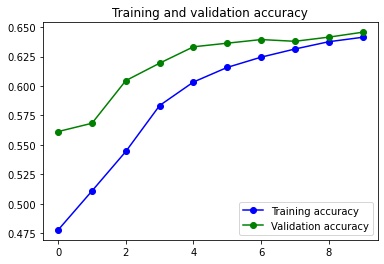

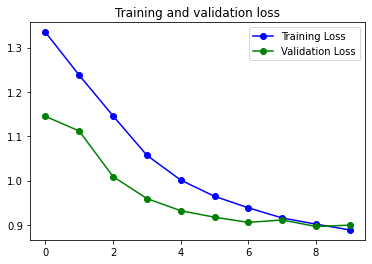

In [18]:
plot_loss_acc(history6)

categorical_crossentropy batch_size=128



sparse_categorical_crossentropy batch_size=128



categorical_crossentropy batch_size=512


In [28]:
# Build the model
model61 = get_model(61)
# Print the model summary
model61.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 48, 100)           1400000   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 48, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_45 (Bidirecti  (None, 48, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_46 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                     

In [29]:
# Set the training parameters
model61.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history61 = model61.fit(padded, y_train, epochs=gEpochs, batch_size=512,
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-29 16:49:09.400286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:09.843384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:09.854541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:10.032181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:10.043008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:10.256104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:10.271555: I tensorflow/core/grappler/optimizers/cust

275/275 [==============================] - ETA: 0s - loss: 1.2219 - accuracy: 0.5166

2022-07-29 16:49:41.712206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:41.855173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:41.863739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:42.003380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:49:42.012248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


275/275 [==============================] - 36s 118ms/step - loss: 1.2219 - accuracy: 0.5166 - val_loss: 1.0498 - val_accuracy: 0.5895
Epoch 2/10
275/275 [==============================] - 30s 107ms/step - loss: 1.0480 - accuracy: 0.5838 - val_loss: 0.9506 - val_accuracy: 0.6259
Epoch 3/10
275/275 [==============================] - 29s 107ms/step - loss: 0.9561 - accuracy: 0.6156 - val_loss: 0.9151 - val_accuracy: 0.6389
Epoch 4/10
275/275 [==============================] - 29s 107ms/step - loss: 0.9114 - accuracy: 0.6329 - val_loss: 0.8950 - val_accuracy: 0.6447
Epoch 5/10
275/275 [==============================] - 29s 106ms/step - loss: 0.8846 - accuracy: 0.6426 - val_loss: 0.8902 - val_accuracy: 0.6457
Epoch 6/10
275/275 [==============================] - 29s 106ms/step - loss: 0.8632 - accuracy: 0.6488 - val_loss: 0.8831 - val_accuracy: 0.6481
Epoch 7/10
275/275 [==============================] - 29s 106ms/step - loss: 0.8492 - accuracy: 0.6529 - val_loss: 0.8845 - val_accuracy: 0.6

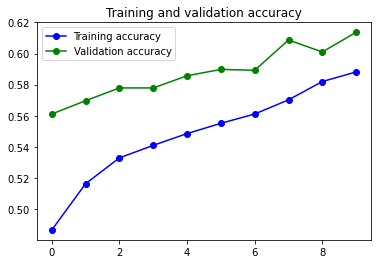

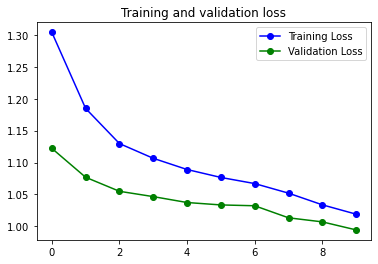

In [22]:
plot_loss_acc(history61)